# Dynamic Component Placement Research

This notebook explores algorithms for dynamically placing newsletter components in a grid layout. This is essentially a 2D bin packing problem where we need to fit components of different sizes into a fixed grid.

## Problem Statement

Given:
- A grid of 12x16 cells
- Components with different sizes and counts
- Components cannot be rotated
- Need to find optimal placement to minimize wasted space

## Component Specifications

From our config:
- 3 headlines: 6x4 each
- 3 secondaries: 6x3 each  
- 3 brandings: 2x2 each
- 3 quick links: 6x1 each


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import random
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
from copy import deepcopy

# Load configuration
with open('../config/component_placement_config.json', 'r') as f:
    config = json.load(f)

print("Grid Configuration:")
print(f"Columns: {config['grid_config']['columns']}")
print(f"Rows: {config['grid_config']['rows']}")
print(f"Cell Size: {config['grid_config']['cell_size']}px")

print("\nComponent Specifications:")
for component in config['components']:
    print(f"- {component['name']}: {component['width']}x{component['height']} (count: {component['count']})")


Grid Configuration:
Columns: 12
Rows: 16
Cell Size: 48px

Component Specifications:
- headline: 6x4 (count: 3)
- secondary: 6x3 (count: 3)
- branding: 2x2 (count: 3)
- quick_link: 6x1 (count: 3)


In [2]:
@dataclass
class Component:
    name: str
    width: int
    height: int
    count: int
    can_rotate: bool
    priority: int
    color: str
    
    def __post_init__(self):
        self.instances = []
        for i in range(self.count):
            self.instances.append({
                'id': f"{self.name}_{i+1}",
                'width': self.width,
                'height': self.height,
                'placed': False,
                'position': None
            })

@dataclass
class Placement:
    component_id: str
    x: int
    y: int
    width: int
    height: int
    color: str

class GridPlacer:
    def __init__(self, grid_width: int, grid_height: int):
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.grid = np.zeros((grid_height, grid_width), dtype=int)
        self.placements = []
        
    def can_place(self, x: int, y: int, width: int, height: int) -> bool:
        """Check if a component can be placed at the given position"""
        if x + width > self.grid_width or y + height > self.grid_height:
            return False
        if x < 0 or y < 0:
            return False
            
        # Check if the area is free
        return np.all(self.grid[y:y+height, x:x+width] == 0)
    
    def place_component(self, component_id: str, x: int, y: int, width: int, height: int, color: str) -> bool:
        """Place a component at the given position"""
        if not self.can_place(x, y, width, height):
            return False
            
        # Mark the grid cells as occupied
        self.grid[y:y+height, x:x+width] = 1
        
        # Add to placements
        self.placements.append(Placement(component_id, x, y, width, height, color))
        return True
    
    def get_available_positions(self, width: int, height: int) -> List[Tuple[int, int]]:
        """Get all available positions for a component of given size"""
        positions = []
        for y in range(self.grid_height - height + 1):
            for x in range(self.grid_width - width + 1):
                if self.can_place(x, y, width, height):
                    positions.append((x, y))
        return positions
    
    def get_first_available_position(self, width: int, height: int) -> Optional[Tuple[int, int]]:
        """Get the first available position (top-left to bottom-right)"""
        positions = self.get_available_positions(width, height)
        return positions[0] if positions else None


In [3]:
def bottom_left_fill_algorithm(components: List[Component], grid_width: int, grid_height: int) -> GridPlacer:
    """
    Bottom-Left Fill algorithm for 2D bin packing
    Places components starting from the bottom-left corner
    """
    placer = GridPlacer(grid_width, grid_height)
    
    # Sort components by priority (lower number = higher priority)
    sorted_components = sorted(components, key=lambda c: c.priority)
    
    for component in sorted_components:
        for instance in component.instances:
            if instance['placed']:
                continue
                
            # Try to find a position for this component
            position = placer.get_first_available_position(instance['width'], instance['height'])
            
            if position:
                x, y = position
                success = placer.place_component(
                    instance['id'], x, y, 
                    instance['width'], instance['height'], 
                    component.color
                )
                if success:
                    instance['placed'] = True
                    instance['position'] = (x, y)
                    print(f"Placed {instance['id']} at ({x}, {y})")
                else:
                    print(f"Failed to place {instance['id']}")
            else:
                print(f"No space for {instance['id']}")
    
    return placer

def visualize_placement(placer: GridPlacer, title: str = "Component Placement"):
    """Visualize the component placement with colorful boxes"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 16))
    
    # Draw grid
    for i in range(placer.grid_height + 1):
        ax.axhline(y=i, color='black', linewidth=0.5, alpha=0.3)
    for i in range(placer.grid_width + 1):
        ax.axvline(x=i, color='black', linewidth=0.5, alpha=0.3)
    
    # Draw placed components
    for placement in placer.placements:
        rect = patches.Rectangle(
            (placement.x, placement.y), 
            placement.width, 
            placement.height,
            linewidth=2, 
            edgecolor='black', 
            facecolor=placement.color,
            alpha=0.7
        )
        ax.add_patch(rect)
        
        # Add component ID text
        center_x = placement.x + placement.width / 2
        center_y = placement.y + placement.height / 2
        ax.text(center_x, center_y, placement.component_id, 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    ax.set_xlim(-0.5, placer.grid_width + 0.5)
    ax.set_ylim(-0.5, placer.grid_height + 0.5)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.invert_yaxis()  # Invert y-axis so (0,0) is top-left
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_cells = placer.grid_width * placer.grid_height
    occupied_cells = np.sum(placer.grid)
    wasted_cells = total_cells - occupied_cells
    efficiency = (occupied_cells / total_cells) * 100
    
    print(f"\nPlacement Statistics:")
    print(f"Total grid cells: {total_cells}")
    print(f"Occupied cells: {occupied_cells}")
    print(f"Wasted cells: {wasted_cells}")
    print(f"Efficiency: {efficiency:.1f}%")
    print(f"Components placed: {len(placer.placements)}")


In [4]:
# Create component objects from config
components = []
for comp_config in config['components']:
    component = Component(
        name=comp_config['name'],
        width=comp_config['width'],
        height=comp_config['height'],
        count=comp_config['count'],
        can_rotate=comp_config['can_rotate'],
        priority=comp_config['priority'],
        color=comp_config['color']
    )
    components.append(component)

# Get grid dimensions
grid_width = config['grid_config']['columns']
grid_height = config['grid_config']['rows']

print(f"Grid size: {grid_width}x{grid_height}")
print(f"Total available cells: {grid_width * grid_height}")

# Calculate total space needed
total_space_needed = 0
for component in components:
    space_per_component = component.width * component.height
    total_space = space_per_component * component.count
    total_space_needed += total_space
    print(f"{component.name}: {space_per_component} cells each × {component.count} = {total_space} cells")

print(f"\nTotal space needed: {total_space_needed} cells")
print(f"Space available: {grid_width * grid_height} cells")
print(f"Can fit: {'Yes' if total_space_needed <= grid_width * grid_height else 'No'}")


Grid size: 12x16
Total available cells: 192
headline: 24 cells each × 3 = 72 cells
secondary: 18 cells each × 3 = 54 cells
branding: 4 cells each × 3 = 12 cells
quick_link: 6 cells each × 3 = 18 cells

Total space needed: 156 cells
Space available: 192 cells
Can fit: Yes


Running Bottom-Left Fill Algorithm...
Placed headline_1 at (0, 0)
Placed headline_2 at (6, 0)
Placed headline_3 at (0, 4)
Placed secondary_1 at (6, 4)
Placed secondary_2 at (6, 7)
Placed secondary_3 at (0, 8)
Placed branding_1 at (6, 10)
Placed branding_2 at (8, 10)
Placed branding_3 at (10, 10)
Placed quick_link_1 at (0, 11)
Placed quick_link_2 at (0, 12)
Placed quick_link_3 at (6, 12)


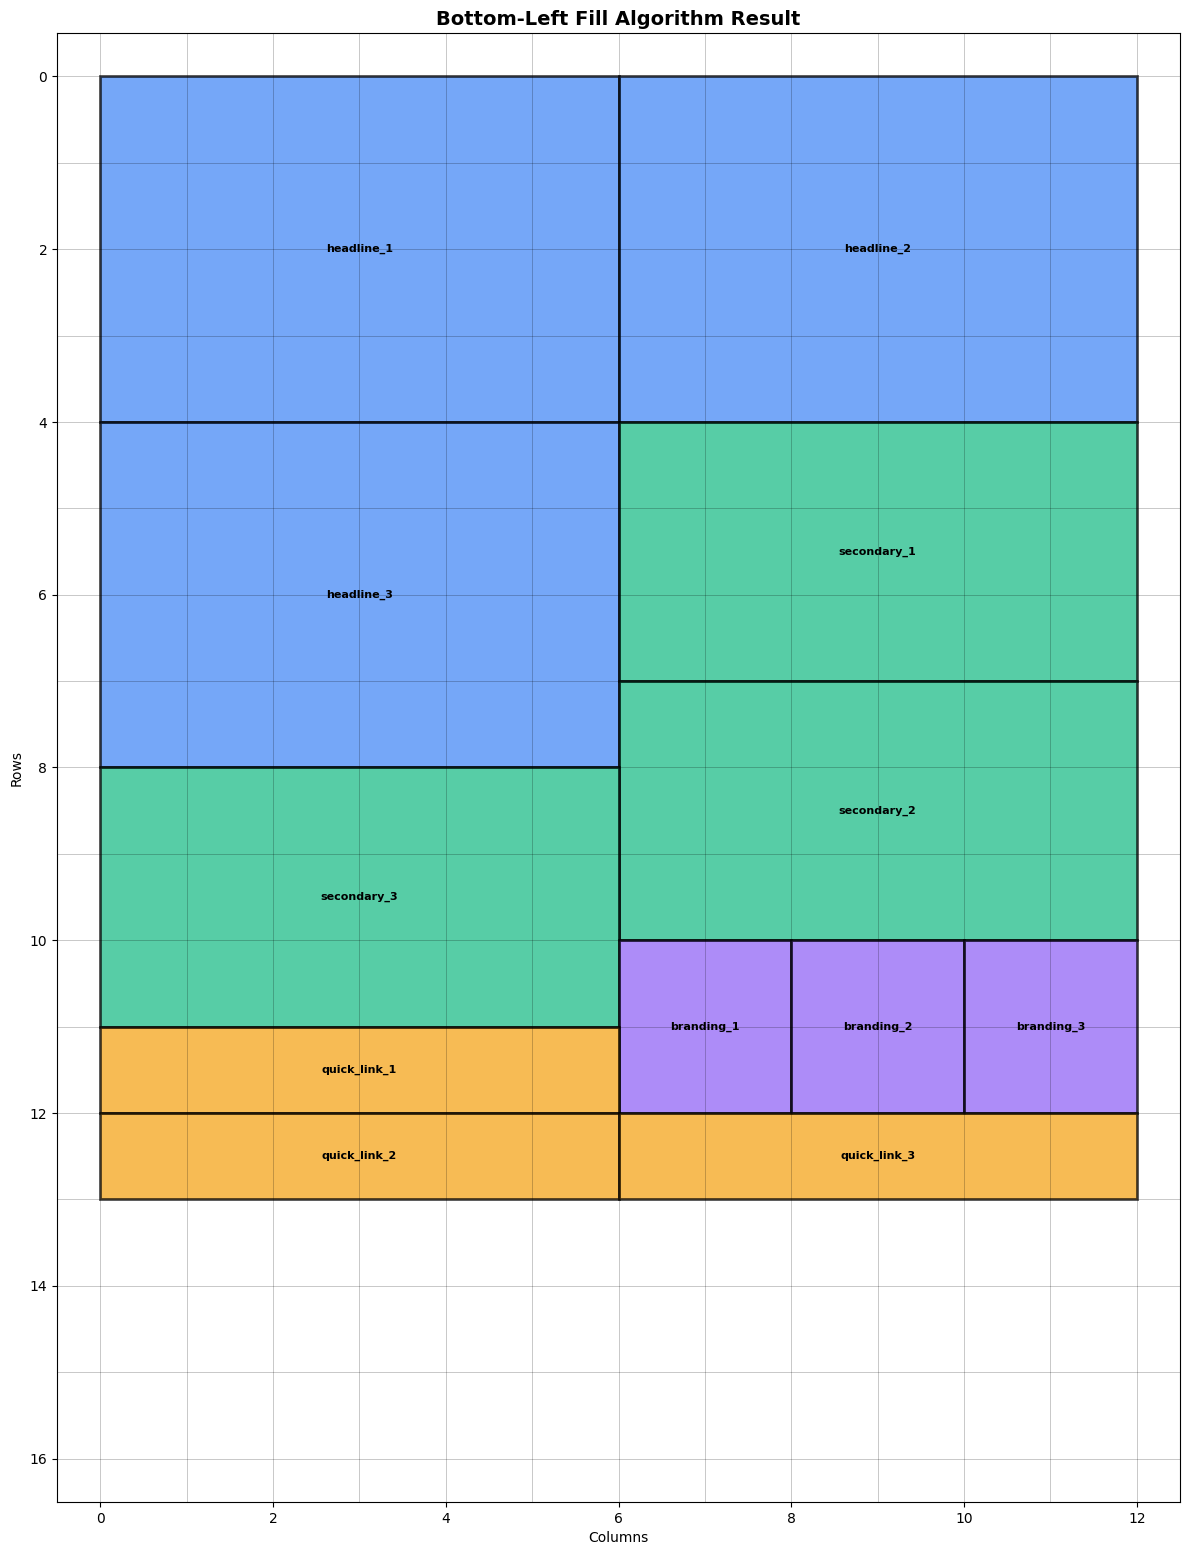


Placement Statistics:
Total grid cells: 192
Occupied cells: 156
Wasted cells: 36
Efficiency: 81.2%
Components placed: 12


In [5]:
# Run the bottom-left fill algorithm
print("Running Bottom-Left Fill Algorithm...")
print("=" * 50)

placer = bottom_left_fill_algorithm(components, grid_width, grid_height)

# Visualize the result
visualize_placement(placer, "Bottom-Left Fill Algorithm Result")


## Alternative Algorithms

Let's explore some alternative placement strategies to see if we can improve the efficiency:


In [6]:
def best_fit_algorithm(components: List[Component], grid_width: int, grid_height: int) -> GridPlacer:
    """
    Best Fit algorithm - tries to find the best position for each component
    by minimizing wasted space
    """
    placer = GridPlacer(grid_width, grid_height)
    
    # Sort components by priority
    sorted_components = sorted(components, key=lambda c: c.priority)
    
    for component in sorted_components:
        for instance in component.instances:
            if instance['placed']:
                continue
                
            # Get all available positions
            positions = placer.get_available_positions(instance['width'], instance['height'])
            
            if not positions:
                print(f"No space for {instance['id']}")
                continue
            
            # For now, just use the first available position
            # In a more sophisticated version, we could evaluate each position
            # based on how much space it wastes or how well it fits
            x, y = positions[0]
            
            success = placer.place_component(
                instance['id'], x, y, 
                instance['width'], instance['height'], 
                component.color
            )
            
            if success:
                instance['placed'] = True
                instance['position'] = (x, y)
                print(f"Placed {instance['id']} at ({x}, {y})")
            else:
                print(f"Failed to place {instance['id']}")
    
    return placer

def largest_first_algorithm(components: List[Component], grid_width: int, grid_height: int) -> GridPlacer:
    """
    Largest First algorithm - places larger components first
    """
    placer = GridPlacer(grid_width, grid_height)
    
    # Create a list of all component instances with their sizes
    all_instances = []
    for component in components:
        for instance in component.instances:
            all_instances.append({
                'instance': instance,
                'component': component,
                'area': instance['width'] * instance['height']
            })
    
    # Sort by area (largest first)
    all_instances.sort(key=lambda x: x['area'], reverse=True)
    
    for item in all_instances:
        instance = item['instance']
        component = item['component']
        
        if instance['placed']:
            continue
            
        # Try to find a position
        position = placer.get_first_available_position(instance['width'], instance['height'])
        
        if position:
            x, y = position
            success = placer.place_component(
                instance['id'], x, y, 
                instance['width'], instance['height'], 
                component.color
            )
            if success:
                instance['placed'] = True
                instance['position'] = (x, y)
                print(f"Placed {instance['id']} at ({x}, {y})")
            else:
                print(f"Failed to place {instance['id']}")
        else:
            print(f"No space for {instance['id']}")
    
    return placer


Testing Largest First Algorithm...
Placed headline_1 at (0, 0)
Placed headline_2 at (6, 0)
Placed headline_3 at (0, 4)
Placed secondary_1 at (6, 4)
Placed secondary_2 at (6, 7)
Placed secondary_3 at (0, 8)
Placed quick_link_1 at (6, 10)
Placed quick_link_2 at (0, 11)
Placed quick_link_3 at (6, 11)
Placed branding_1 at (0, 12)
Placed branding_2 at (2, 12)
Placed branding_3 at (4, 12)


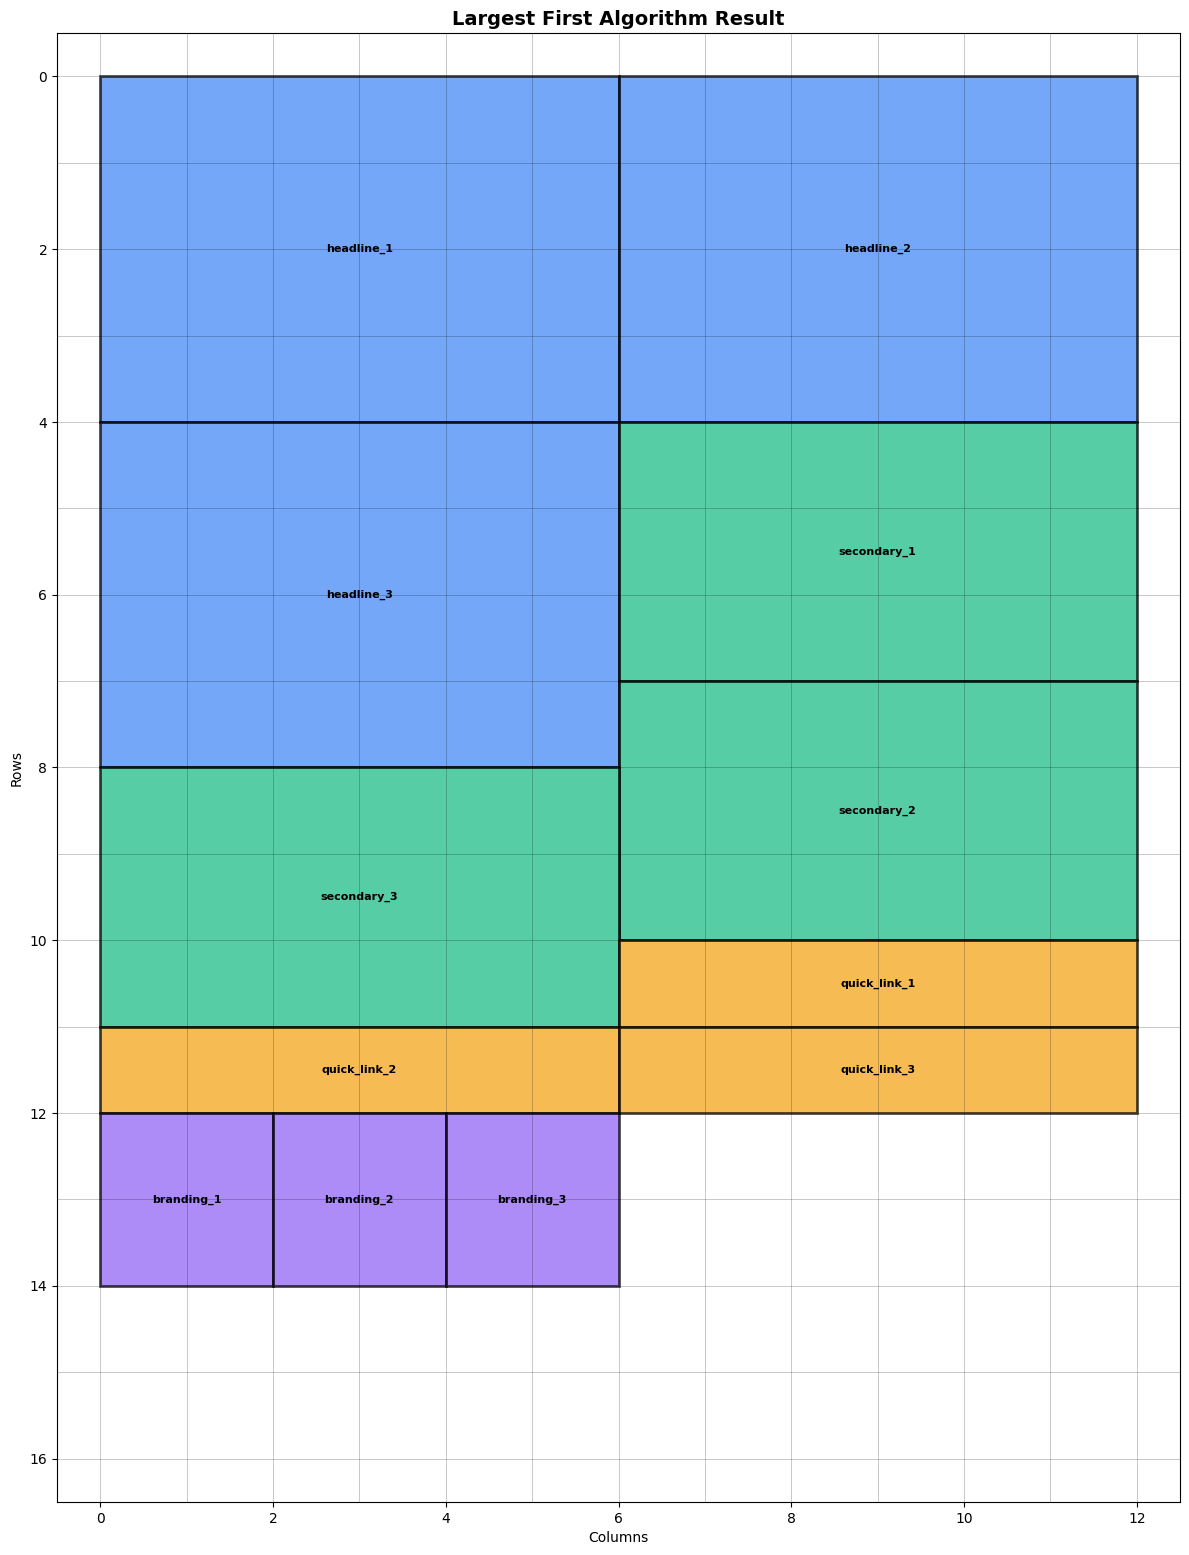


Placement Statistics:
Total grid cells: 192
Occupied cells: 156
Wasted cells: 36
Efficiency: 81.2%
Components placed: 12


In [7]:
# Reset component instances for testing different algorithms
def reset_components(components):
    for component in components:
        for instance in component.instances:
            instance['placed'] = False
            instance['position'] = None

# Test Largest First Algorithm
print("Testing Largest First Algorithm...")
print("=" * 50)
reset_components(components)
placer_largest = largest_first_algorithm(components, grid_width, grid_height)
visualize_placement(placer_largest, "Largest First Algorithm Result")


## Algorithm Comparison

Let's compare the efficiency of different algorithms:



Bottom-Left Fill Algorithm:
------------------------------
Placed headline_1 at (0, 0)
Placed headline_2 at (6, 0)
Placed headline_3 at (0, 4)
Placed secondary_1 at (6, 4)
Placed secondary_2 at (6, 7)
Placed secondary_3 at (0, 8)
Placed branding_1 at (6, 10)
Placed branding_2 at (8, 10)
Placed branding_3 at (10, 10)
Placed quick_link_1 at (0, 11)
Placed quick_link_2 at (0, 12)
Placed quick_link_3 at (6, 12)
Efficiency: 81.2%
Wasted cells: 36
Components placed: 12

Largest First Algorithm:
------------------------------
Placed headline_1 at (0, 0)
Placed headline_2 at (6, 0)
Placed headline_3 at (0, 4)
Placed secondary_1 at (6, 4)
Placed secondary_2 at (6, 7)
Placed secondary_3 at (0, 8)
Placed quick_link_1 at (6, 10)
Placed quick_link_2 at (0, 11)
Placed quick_link_3 at (6, 11)
Placed branding_1 at (0, 12)
Placed branding_2 at (2, 12)
Placed branding_3 at (4, 12)
Efficiency: 81.2%
Wasted cells: 36
Components placed: 12


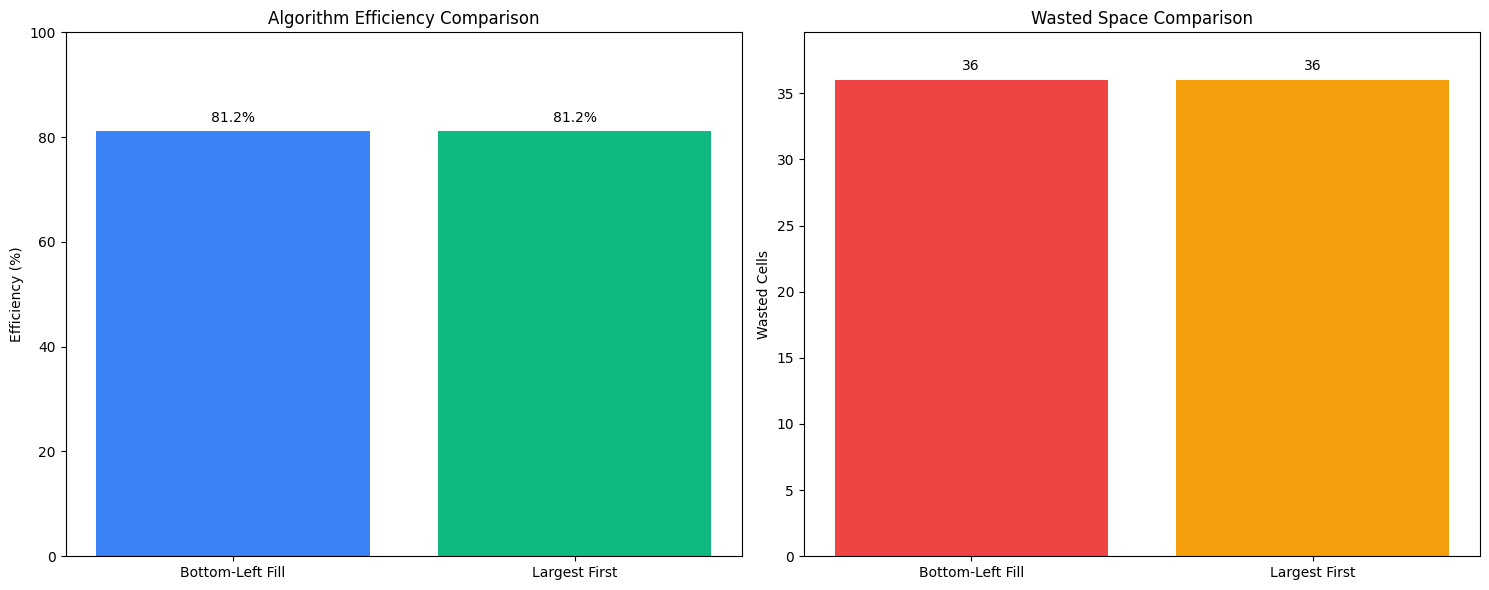


ALGORITHM COMPARISON SUMMARY
Bottom-Left Fill:
  - Efficiency: 81.2%
  - Wasted cells: 36
  - Components placed: 12

Largest First:
  - Efficiency: 81.2%
  - Wasted cells: 36
  - Components placed: 12



In [8]:
def compare_algorithms(components, grid_width, grid_height):
    """Compare different placement algorithms"""
    algorithms = [
        ("Bottom-Left Fill", bottom_left_fill_algorithm),
        ("Largest First", largest_first_algorithm),
    ]
    
    results = []
    
    for name, algorithm in algorithms:
        print(f"\n{name} Algorithm:")
        print("-" * 30)
        
        # Reset components
        reset_components(components)
        
        # Run algorithm
        placer = algorithm(components, grid_width, grid_height)
        
        # Calculate efficiency
        total_cells = grid_width * grid_height
        occupied_cells = np.sum(placer.grid)
        efficiency = (occupied_cells / total_cells) * 100
        wasted_cells = total_cells - occupied_cells
        
        results.append({
            'name': name,
            'efficiency': efficiency,
            'wasted_cells': wasted_cells,
            'placed_components': len(placer.placements)
        })
        
        print(f"Efficiency: {efficiency:.1f}%")
        print(f"Wasted cells: {wasted_cells}")
        print(f"Components placed: {len(placer.placements)}")
    
    return results

# Run comparison
results = compare_algorithms(components, grid_width, grid_height)

# Create comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Efficiency comparison
names = [r['name'] for r in results]
efficiencies = [r['efficiency'] for r in results]
wasted = [r['wasted_cells'] for r in results]

ax1.bar(names, efficiencies, color=['#3B82F6', '#10B981'])
ax1.set_title('Algorithm Efficiency Comparison')
ax1.set_ylabel('Efficiency (%)')
ax1.set_ylim(0, 100)

# Add value labels on bars
for i, v in enumerate(efficiencies):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# Wasted space comparison
ax2.bar(names, wasted, color=['#EF4444', '#F59E0B'])
ax2.set_title('Wasted Space Comparison')
ax2.set_ylabel('Wasted Cells')
ax2.set_ylim(0, max(wasted) * 1.1)

# Add value labels on bars
for i, v in enumerate(wasted):
    ax2.text(i, v + 0.5, f'{v}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*50)
print("ALGORITHM COMPARISON SUMMARY")
print("="*50)
for result in results:
    print(f"{result['name']}:")
    print(f"  - Efficiency: {result['efficiency']:.1f}%")
    print(f"  - Wasted cells: {result['wasted_cells']}")
    print(f"  - Components placed: {result['placed_components']}")
    print()


## Export Solution for Frontend

Let's export the best solution in a format that can be used by the frontend:


In [9]:
def export_to_frontend_format(placer: GridPlacer, components: List[Component]) -> dict:
    """Export the placement solution in frontend-compatible format"""
    
    # Create component mapping for easy lookup
    component_map = {}
    for component in components:
        for instance in component.instances:
            component_map[instance['id']] = component
    
    # Convert placements to frontend format
    frontend_components = []
    
    for placement in placer.placements:
        component = component_map[placement.component_id]
        
        # Determine component type based on name
        if 'headline' in placement.component_id:
            comp_type = 'headline'
        elif 'secondary' in placement.component_id:
            comp_type = 'secondary'
        elif 'branding' in placement.component_id:
            comp_type = 'branding'
        elif 'quick_link' in placement.component_id:
            comp_type = 'quickLink'
        else:
            comp_type = 'unknown'
        
        frontend_component = {
            'id': placement.component_id,
            'type': comp_type,
            'position': {
                'row': placement.y + 1,  # Frontend uses 1-based indexing
                'column': placement.x + 1,
                'width': placement.width,
                'height': placement.height
            },
            'clickable': True,
            'url': f'https://example.com/{placement.component_id}'
        }
        
        # Add type-specific properties
        if comp_type == 'headline':
            frontend_component.update({
                'title': f'Headline {placement.component_id.split("_")[1]}',
                'description': f'Description for {placement.component_id}',
                'source': 'Tech News',
                'publishedAt': '2025-01-27T10:00:00Z',
                'priority': 1
            })
        elif comp_type == 'secondary':
            frontend_component.update({
                'title': f'Secondary {placement.component_id.split("_")[1]}',
                'description': f'Description for {placement.component_id}',
                'source': 'Tech News',
                'publishedAt': '2025-01-27T09:30:00Z',
                'priority': 2
            })
        elif comp_type == 'branding':
            frontend_component.update({
                'text': 'BIT' if 'bit' in placement.component_id else 'BY',
                'variant': 'bit' if 'bit' in placement.component_id else 'by'
            })
        elif comp_type == 'quickLink':
            frontend_component.update({
                'title': f'Quick Link {placement.component_id.split("_")[1]}'
            })
        
        frontend_components.append(frontend_component)
    
    # Create the complete layout
    layout = {
        'gridConfig': {
            'columns': placer.grid_width,
            'rows': placer.grid_height,
            'cellSize': 48
        },
        'components': frontend_components
    }
    
    return layout

# Get the best solution (let's use the largest first algorithm result)
reset_components(components)
best_placer = largest_first_algorithm(components, grid_width, grid_height)

# Export to frontend format
frontend_layout = export_to_frontend_format(best_placer, components)

# Save to file
import json
with open('../data/optimized_layout.json', 'w') as f:
    json.dump(frontend_layout, f, indent=2)

print("Frontend layout exported to: ../data/optimized_layout.json")
print(f"Total components: {len(frontend_layout['components'])}")

# Display the exported layout
print("\nExported Layout Preview:")
print("=" * 40)
for comp in frontend_layout['components']:
    pos = comp['position']
    print(f"{comp['id']}: {comp['type']} at ({pos['column']}, {pos['row']}) - {pos['width']}x{pos['height']}")


Placed headline_1 at (0, 0)
Placed headline_2 at (6, 0)
Placed headline_3 at (0, 4)
Placed secondary_1 at (6, 4)
Placed secondary_2 at (6, 7)
Placed secondary_3 at (0, 8)
Placed quick_link_1 at (6, 10)
Placed quick_link_2 at (0, 11)
Placed quick_link_3 at (6, 11)
Placed branding_1 at (0, 12)
Placed branding_2 at (2, 12)
Placed branding_3 at (4, 12)
Frontend layout exported to: ../data/optimized_layout.json
Total components: 12

Exported Layout Preview:
headline_1: headline at (1, 1) - 6x4
headline_2: headline at (7, 1) - 6x4
headline_3: headline at (1, 5) - 6x4
secondary_1: secondary at (7, 5) - 6x3
secondary_2: secondary at (7, 8) - 6x3
secondary_3: secondary at (1, 9) - 6x3
quick_link_1: quickLink at (7, 11) - 6x1
quick_link_2: quickLink at (1, 12) - 6x1
quick_link_3: quickLink at (7, 12) - 6x1
branding_1: branding at (1, 13) - 2x2
branding_2: branding at (3, 13) - 2x2
branding_3: branding at (5, 13) - 2x2
